# A Quick Tutorial of Taking Numerical Derivative of Noisy Data with PyNumDiff

This notebook walks through each of the methods implemented in PyNumDiff.

In [1]:
import pynumdiff
from pynumdiff.utils import simulate, evaluate

### Notations:
  * dt: (float) time step
  * x: (np.array with length N) the noisy time series you want to differentiate
  * x_hat: (np.array like x) the smoothed estimate of x
  * x_truth: (np.array like x) the true value of x (which is accessible when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array like x) the estimate of the derivative of x
  * dxdt_truth: (np.array like x) the true value of dxdt (which is accessible when the data is simulated, and used for plotting purposes only)

## 0. Simulate synthetic data

### PyNumDiff comes with 6 different toy problems:
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* linear_autonomous: (linear) linear time invariant system: dx/dt = Ax  
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_cruise_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
noise_type = 'normal' # noise is generated using np.random, e.g. 'normal', 'uniform', 'poisson'
noise_parameters = [0, 0.1]  # compatible with np.random functions 

dt = 0.01 # step size and series length in terms of independent variable
duration = 4

x, x_truth, dxdt_truth = simulate.pi_cruise_control(duration=duration, dt=dt, 
                                                noise_type=noise_type, noise_parameters=noise_parameters)

## 1. Smooth Finite Difference

### 1.1 Kernel smoothing

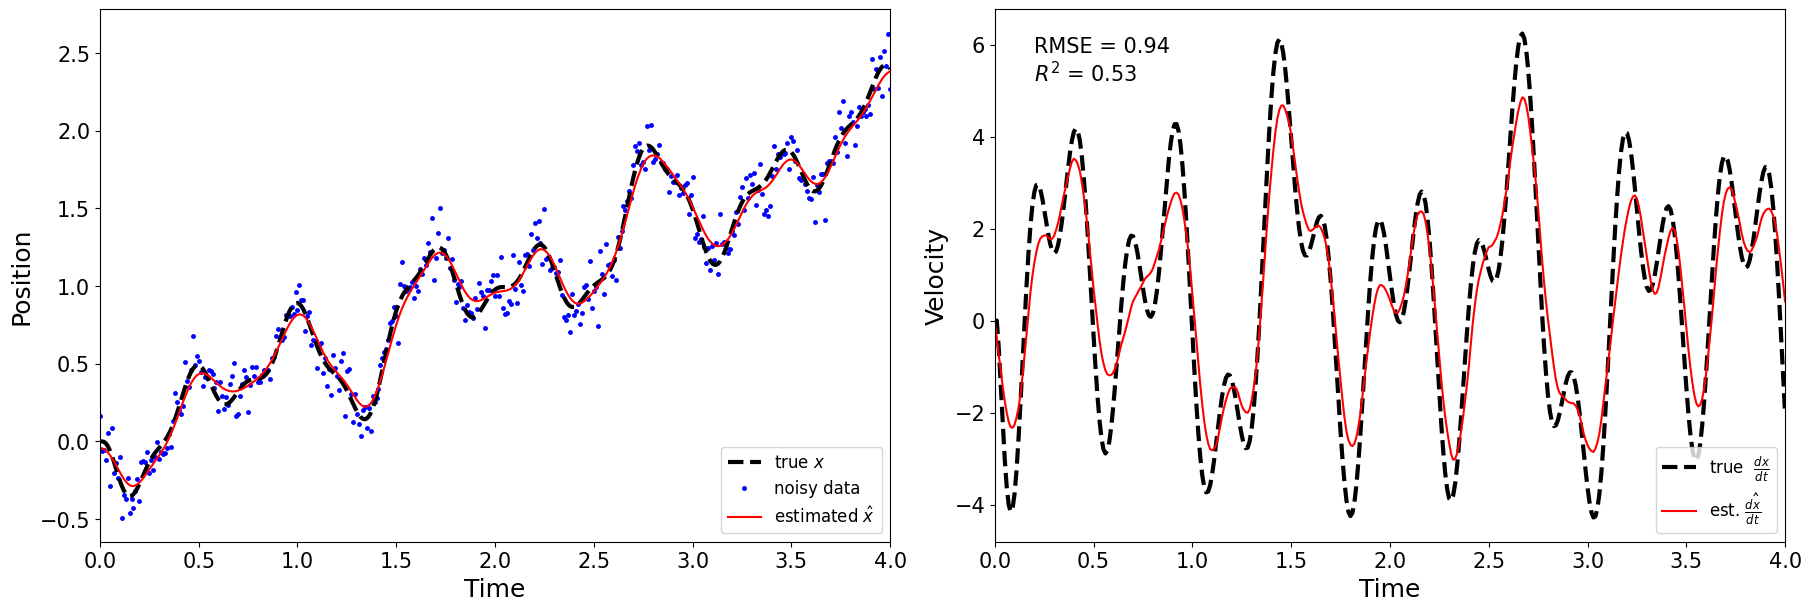

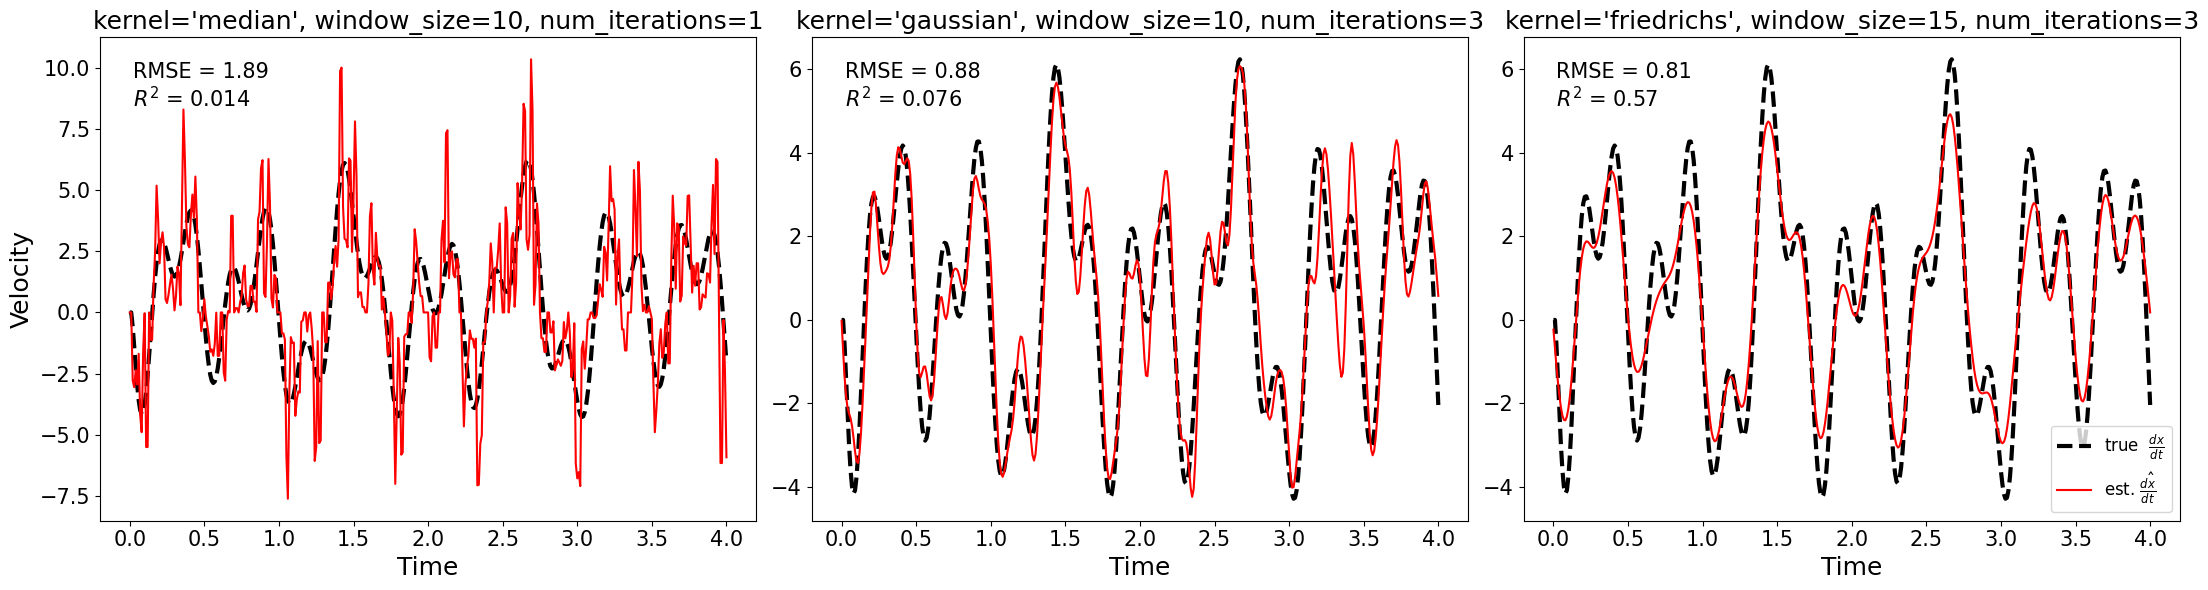

In [3]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.kerneldiff(x, dt, kernel='mean', window_size=10, num_iterations=3)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.smooth_finite_difference.kerneldiff(x, dt, kernel='median', window_size=10, num_iterations=1)
_, dxdt_hat2 = pynumdiff.smooth_finite_difference.kerneldiff(x, dt, kernel='gaussian', window_size=10, num_iterations=3)
_, dxdt_hat3 = pynumdiff.smooth_finite_difference.kerneldiff(x, dt, kernel='friedrichs', window_size=15, num_iterations=3)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, "kernel='median', window_size=10, num_iterations=1",
                         dxdt_hat2, "kernel='gaussian', window_size=10, num_iterations=3",
                         dxdt_hat3, "kernel='friedrichs', window_size=15, num_iterations=3")

### 1.2 Butterworth smoothing

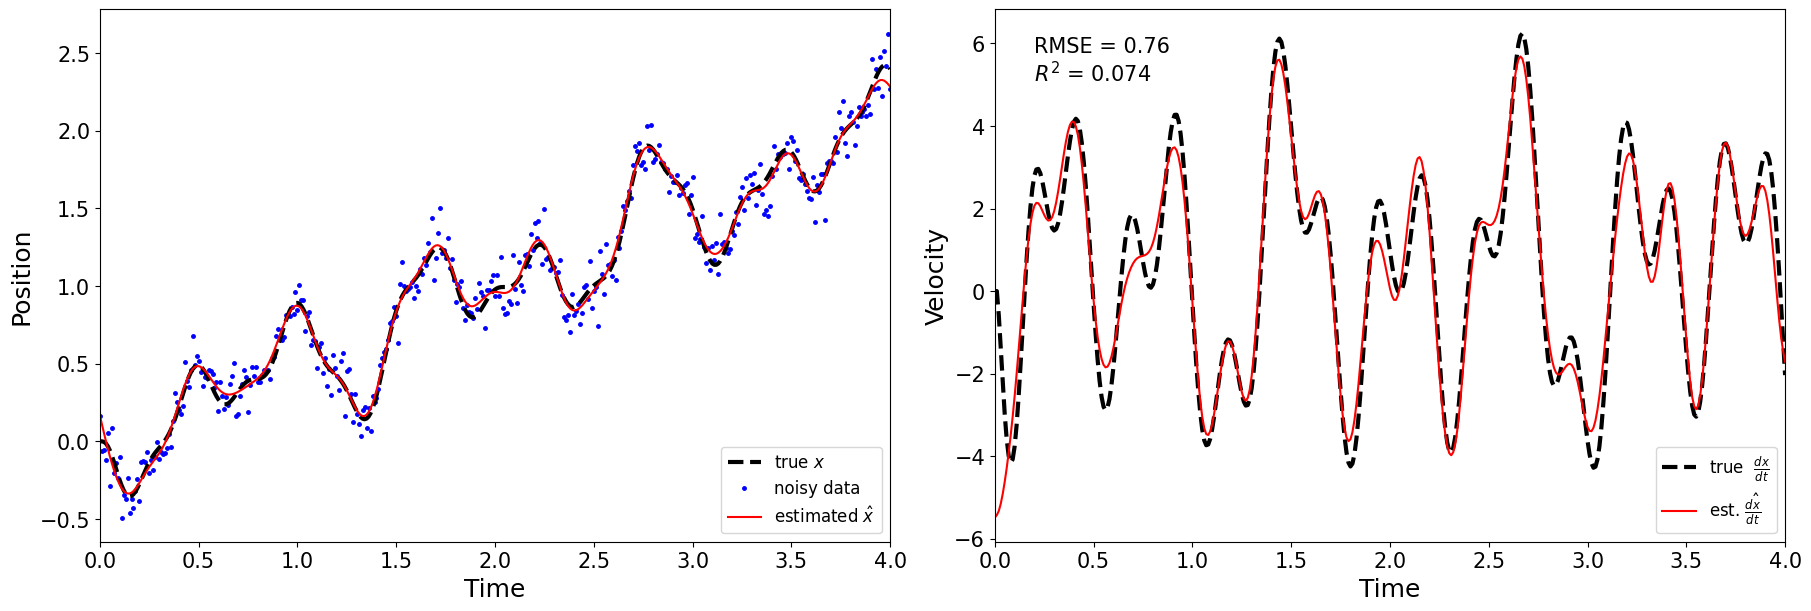

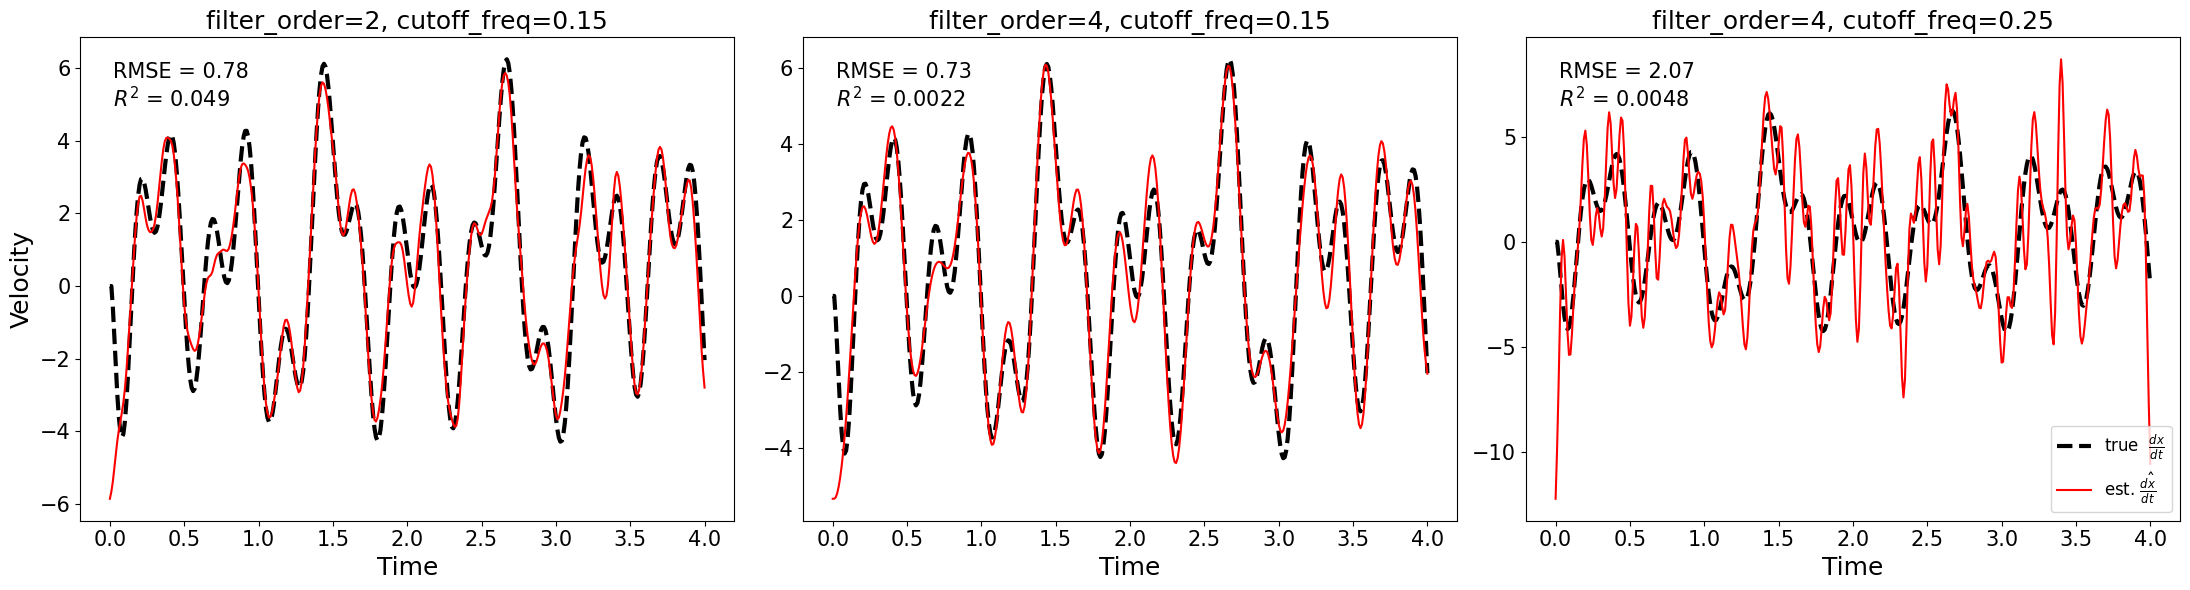

In [4]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, filter_order=3, cutoff_freq=0.09)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.smooth_finite_difference.butterdiff(x, dt, filter_order=2, cutoff_freq=0.1)
_, dxdt_hat2 = pynumdiff.smooth_finite_difference.butterdiff(x, dt, filter_order=4, cutoff_freq=0.1)
_, dxdt_hat3 = pynumdiff.smooth_finite_difference.butterdiff(x, dt, filter_order=4, cutoff_freq=0.25)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, 'filter_order=2, cutoff_freq=0.15',
                         dxdt_hat2, 'filter_order=4, cutoff_freq=0.15',
                         dxdt_hat3, 'filter_order=4, cutoff_freq=0.25')

## 2. Iterated Finite Difference

Here we use the general `finitediff` function. There are also module functions `first_order`, `second_order`, and `fourth_order`, which call the general function, with `order=1`, `2`, or `4`, respectively.

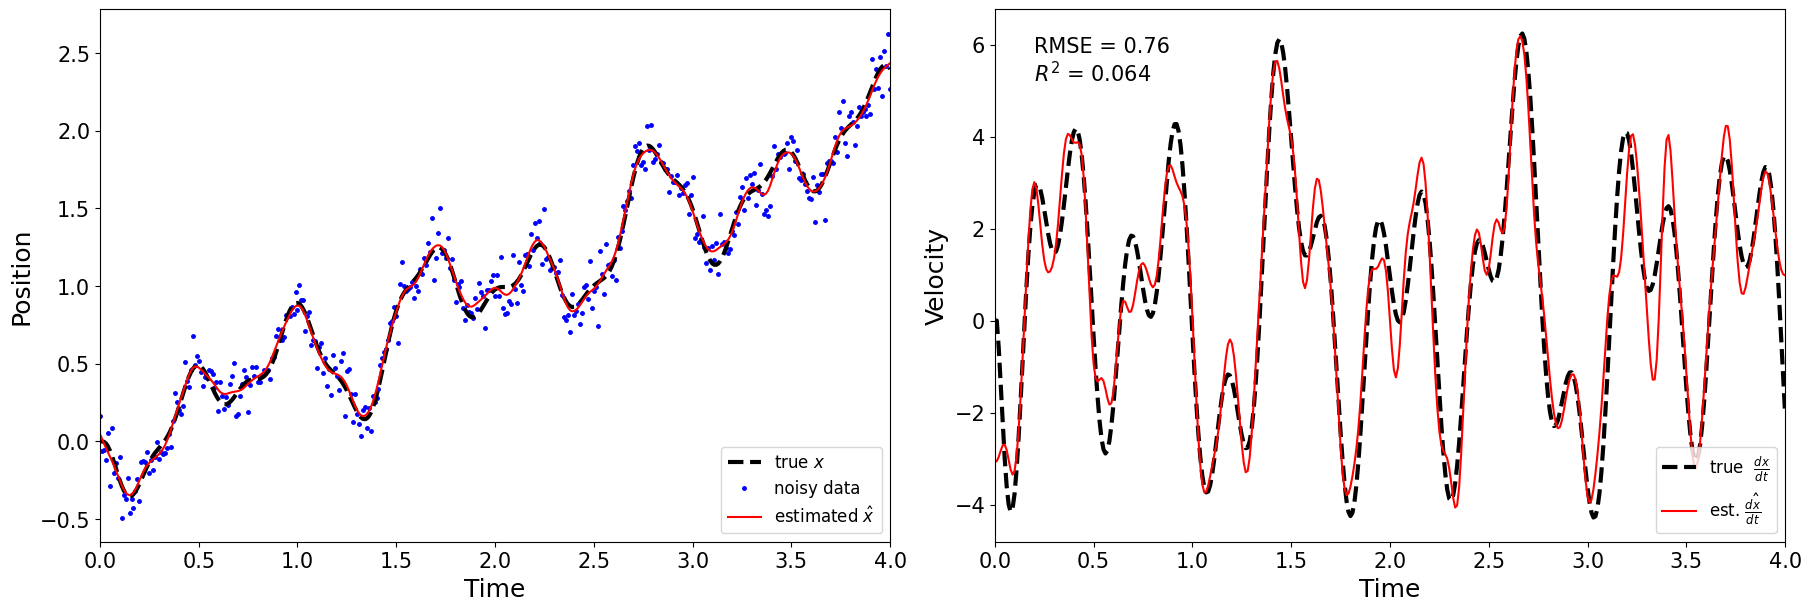

In [5]:
x_hat, dxdt_hat = pynumdiff.finitediff(x, dt, num_iterations=50, order=4)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 2.1 In the presence of noise, iterating is essential

Without iteration, finite difference methods really exaggerate noise, and some even incur extra blowup at the edges, because the FD formulas for the edges have large constants in the numerator, which amplify noise.

In [6]:
x_hat, dxdt_hat = pynumdiff.finite_difference.second_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 2.2 Iterating first order causes a nasty shift

Note that iterating with `order=1` causes a shift, because the FD formula isn't centered:

In [7]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt, num_iterations=20)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 2.3 Comparison of orders

In [8]:
_, dxdt_hat1 = pynumdiff.finite_difference.second_order(x, dt, num_iterations=30)
_, dxdt_hat2 = pynumdiff.finite_difference.fourth_order(x, dt, num_iterations=30)
_, dxdt_hat3 = pynumdiff.finite_difference.fourth_order(x, dt, num_iterations=70)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, 'second_order; num_iterations=30',
                         dxdt_hat2, 'fourth_order; num_iterations=30',
                         dxdt_hat3, 'fourth_order; num_iterations=70')

## 3. Polynomial Fit

### 3.1 Sliding polynomial fit

A global polynomial fit with low degree is heavily-constrained and can't fit many data points, but a high degree polynomial results in Runge phenomenon. Moderate the number of fit points by operating in a sliding window.

/Users/pavel/Code/PyNumDiff/pynumdiff/polynomial_fit/_polynomial_fit.py:84: UserWarning: Kernel window size should be odd. Added 1 to length.
  warn("Kernel window size should be odd. Added 1 to length.")


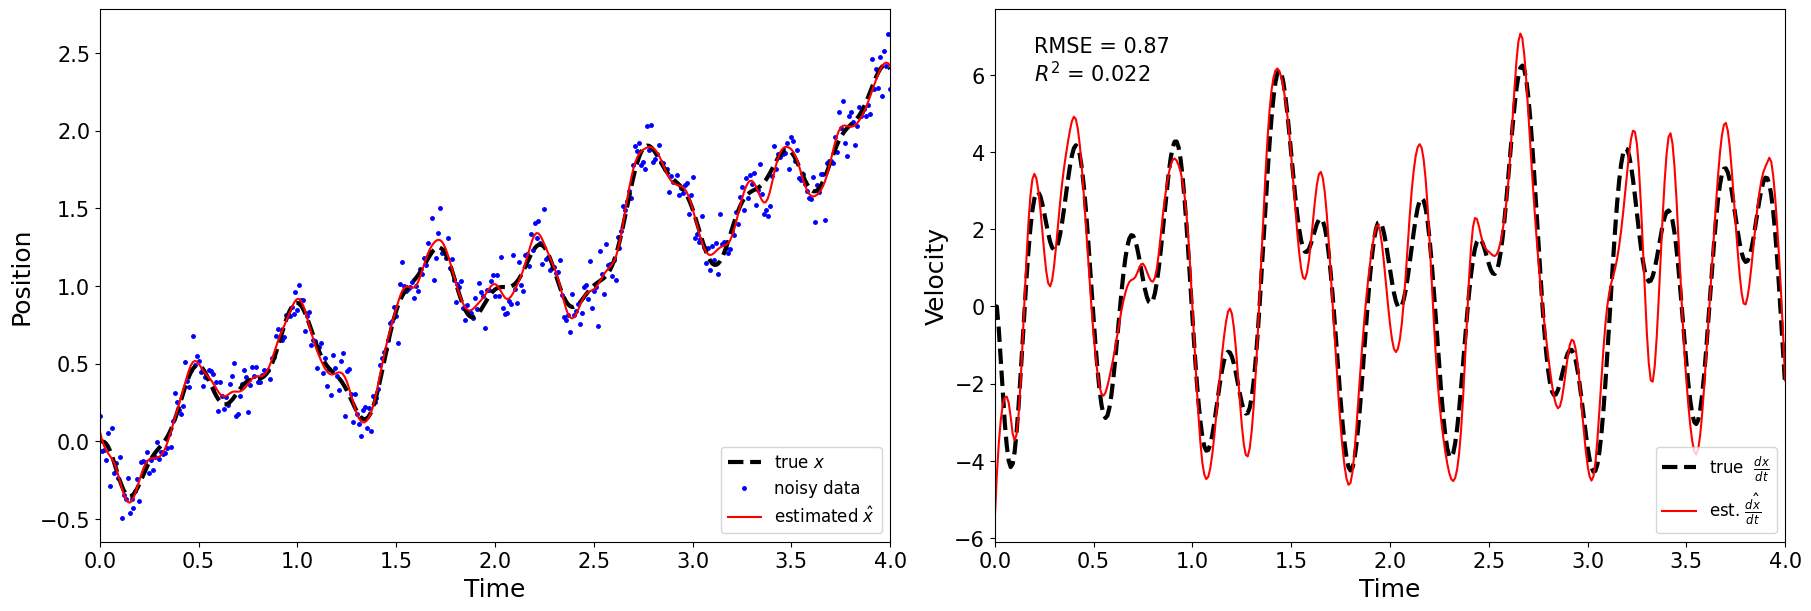

In [9]:
x_hat, dxdt_hat = pynumdiff.polynomial_fit.polydiff(x, dt, degree=2, window_size=21)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.polynomial_fit.polydiff(x, dt, degree=2, kernel='friedrichs', window_size=40, step_size=1)
_, dxdt_hat2 = pynumdiff.polynomial_fit.polydiff(x, dt, degree=3, kernel='friedrichs', window_size=40, step_size=5)
_, dxdt_hat3 = pynumdiff.polynomial_fit.polydiff(x, dt, degree=3, kernel='gaussian', window_size=40, step_size=5)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, "degree=2, kernel='friedrichs',\nwindow_size=40, step_size=1",
                         dxdt_hat2, "degree=3, kernel='friedrichs',\nwindow_size=40, step_size=5",
                         dxdt_hat3, "degree=3, kernel='gaussian',\nwindow_size=40, step_size=5")

### 3.2 Savitzky-Golay filter

/Users/pavel/Code/PyNumDiff/pynumdiff/polynomial_fit/_polynomial_fit.py:132: UserWarning: Kernel window size should be odd. Added 1 to length.
  warn("Kernel window size should be odd. Added 1 to length.")


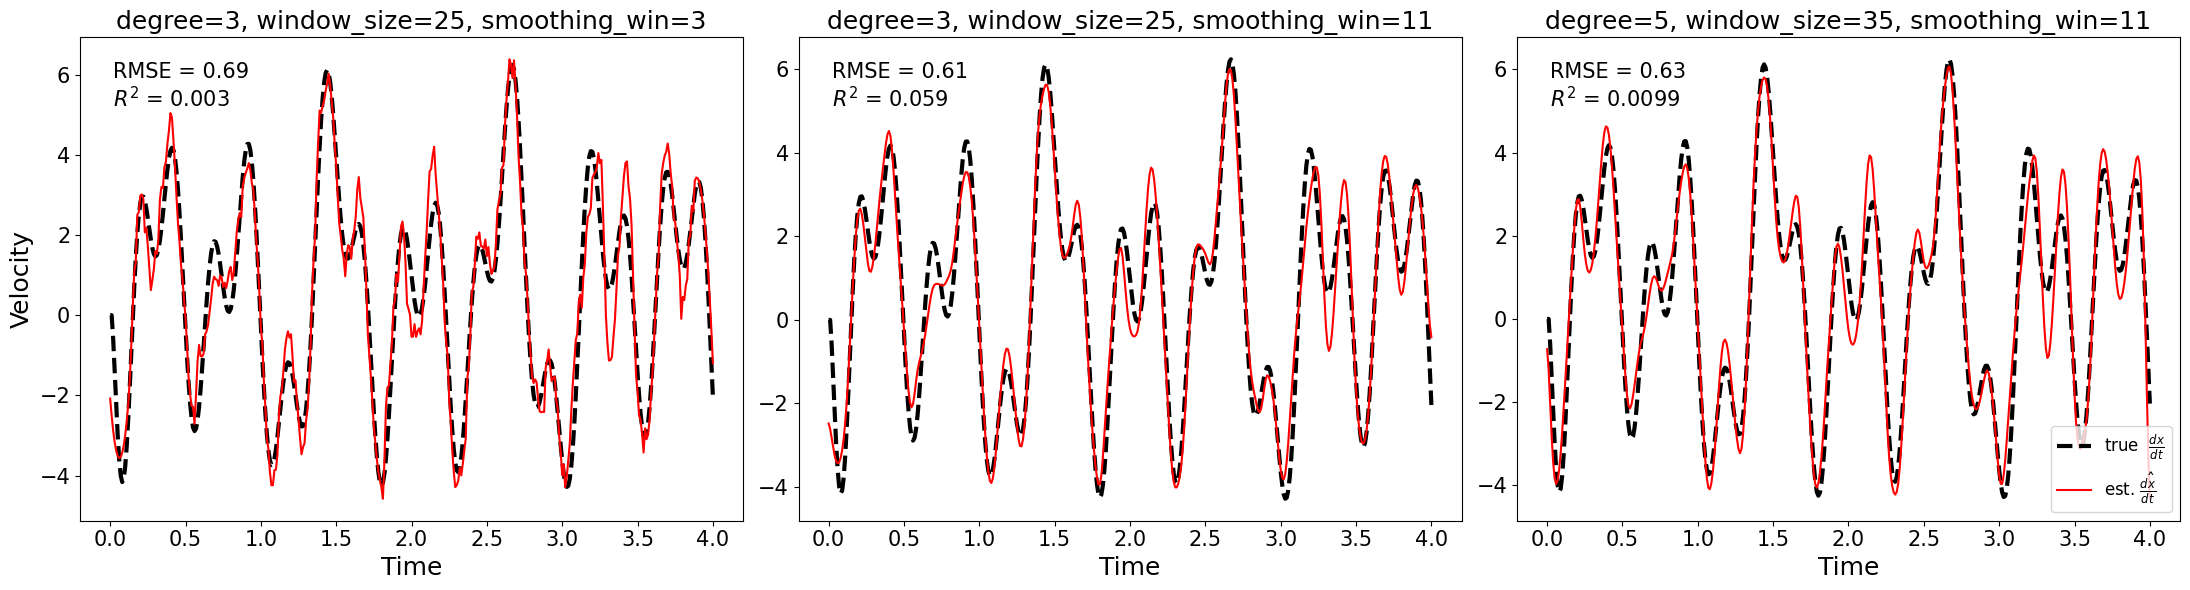

In [10]:
x_hat, dxdt_hat = pynumdiff.polynomial_fit.savgoldiff(x, dt, degree=2, window_size=10, smoothing_win=10)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.polynomial_fit.savgoldiff(x, dt, degree=3, window_size=25, smoothing_win=3)
_, dxdt_hat2 = pynumdiff.polynomial_fit.savgoldiff(x, dt, degree=3, window_size=25, smoothing_win=11)
_, dxdt_hat3 = pynumdiff.polynomial_fit.savgoldiff(x, dt, degree=5, window_size=35, smoothing_win=11)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, "degree=3, window_size=25, smoothing_win=3",
                         dxdt_hat2, "degree=3, window_size=25, smoothing_win=11",
                         dxdt_hat3, "degree=5, window_size=35, smoothing_win=11")

### 3.3 Splines

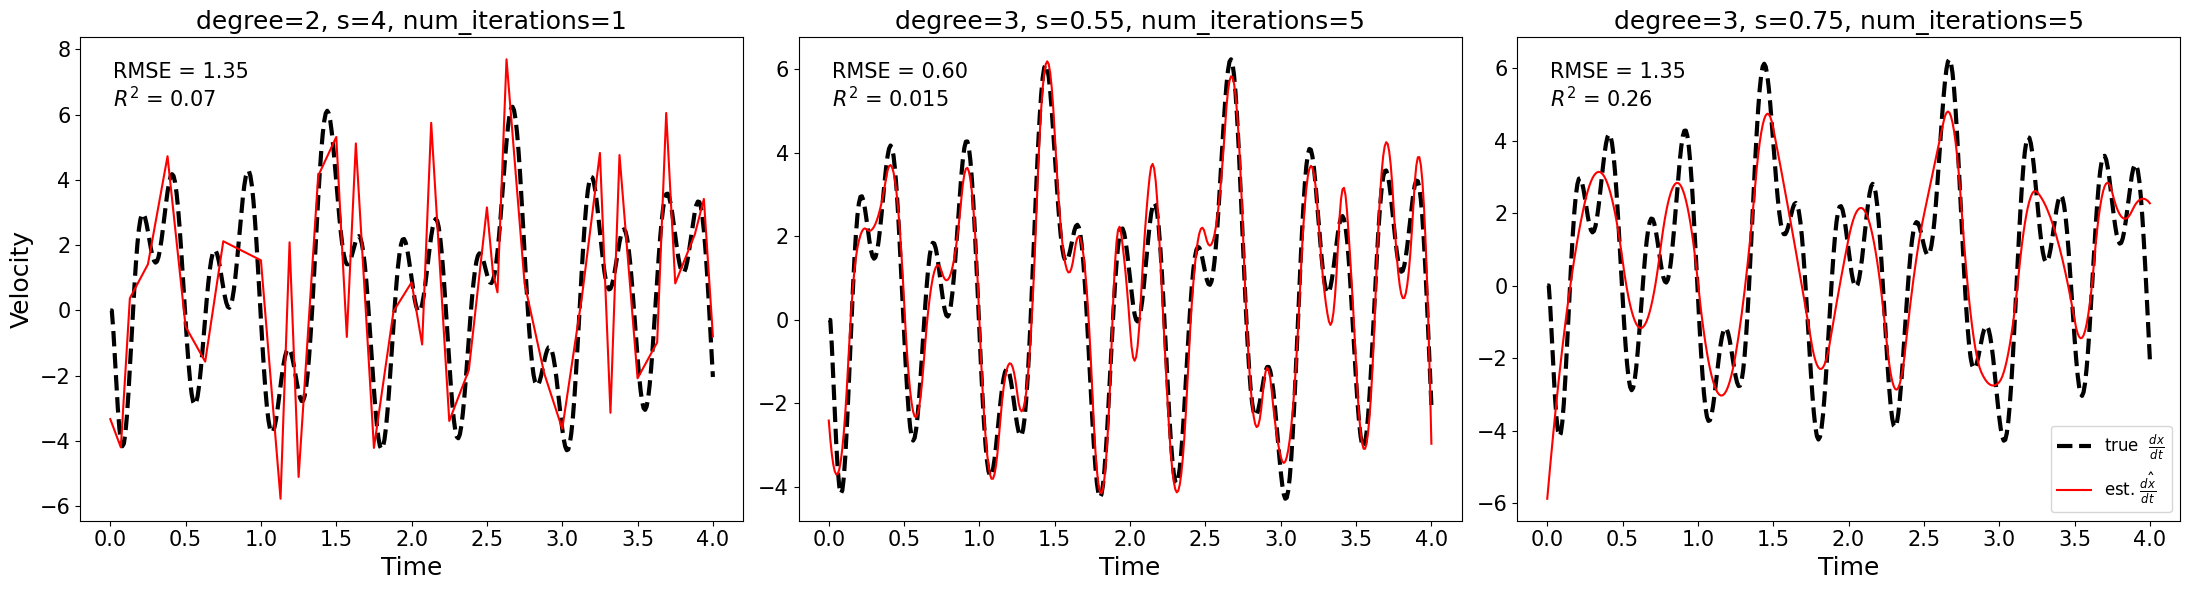

In [11]:
x_hat, dxdt_hat = pynumdiff.polynomial_fit.splinediff(x, dt, degree=3, s=0.6, num_iterations=5)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.polynomial_fit.splinediff(x, dt, degree=2, s=4, num_iterations=1)
_, dxdt_hat2 = pynumdiff.polynomial_fit.splinediff(x, dt, degree=3, s=0.55, num_iterations=5)
_, dxdt_hat3 = pynumdiff.polynomial_fit.splinediff(x, dt, degree=3, s=0.75, num_iterations=5)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, 'degree=2, s=4, num_iterations=1',
                         dxdt_hat2, 'degree=3, s=0.55, num_iterations=5',
                         dxdt_hat3, 'degree=3, s=0.75, num_iterations=5')

## 4. Basis Function Fit

### 4.1 Fourier Spectral derivative

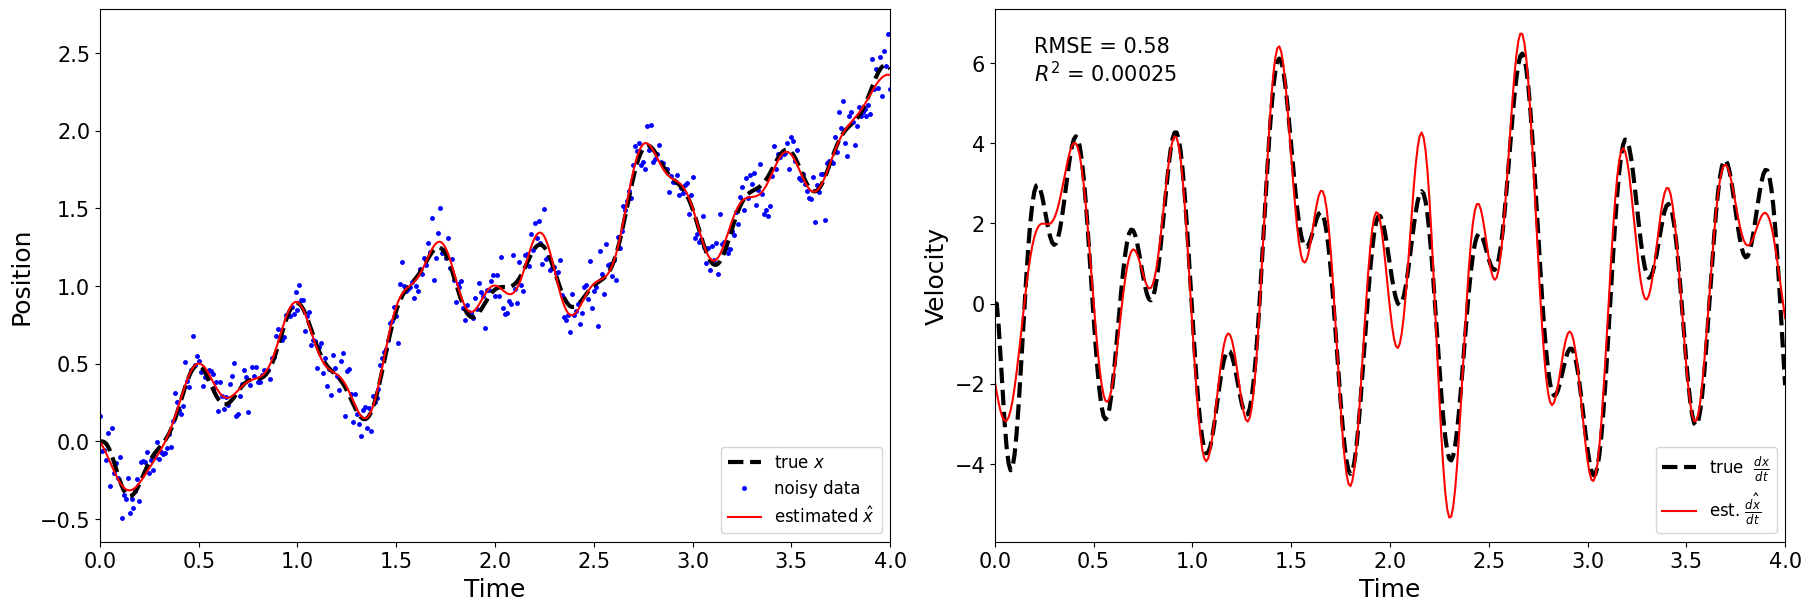

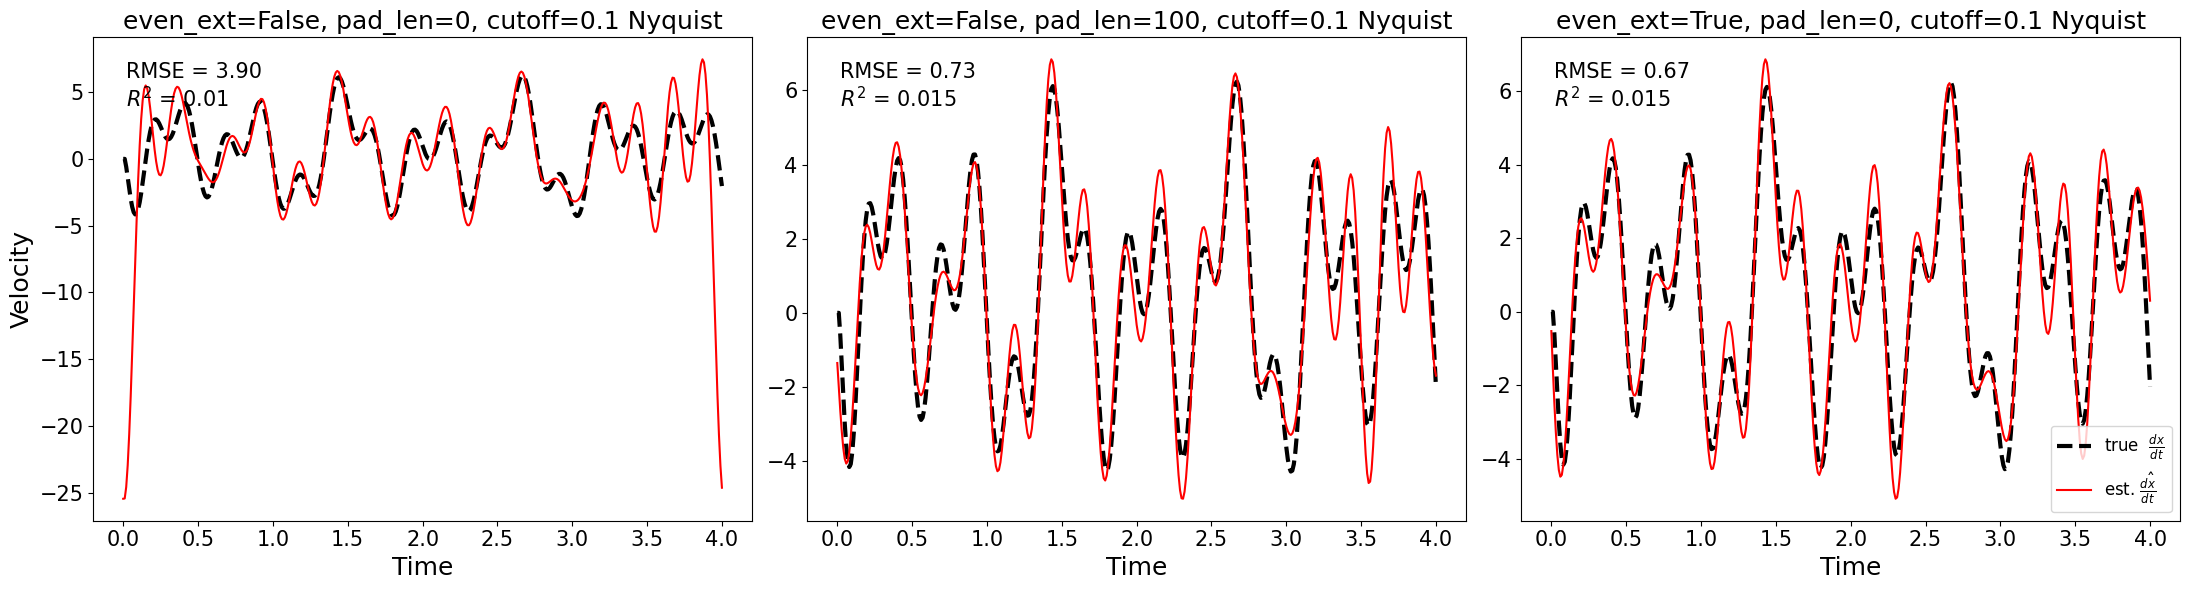

In [12]:
x_hat, dxdt_hat = pynumdiff.basis_fit.spectraldiff(x, dt, even_extension=True, pad_to_zero_dxdt=True, high_freq_cutoff=0.085)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.basis_fit.spectraldiff(x, dt, even_extension=False, pad_to_zero_dxdt=False, high_freq_cutoff=0.1)
_, dxdt_hat2 = pynumdiff.basis_fit.spectraldiff(x, dt, even_extension=False, pad_to_zero_dxdt=True, high_freq_cutoff=0.1)
_, dxdt_hat3 = pynumdiff.basis_fit.spectraldiff(x, dt, even_extension=True, pad_to_zero_dxdt=False, high_freq_cutoff=0.1)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, 'even_ext=False, pad_len=0, cutoff=0.1 Nyquist',
                           dxdt_hat2, 'even_ext=False, pad_len=100, cutoff=0.1 Nyquist',
                           dxdt_hat3, 'even_ext=True, pad_len=0, cutoff=0.1 Nyquist')

### 4.2 Radial-Basis-Function fit and derivative

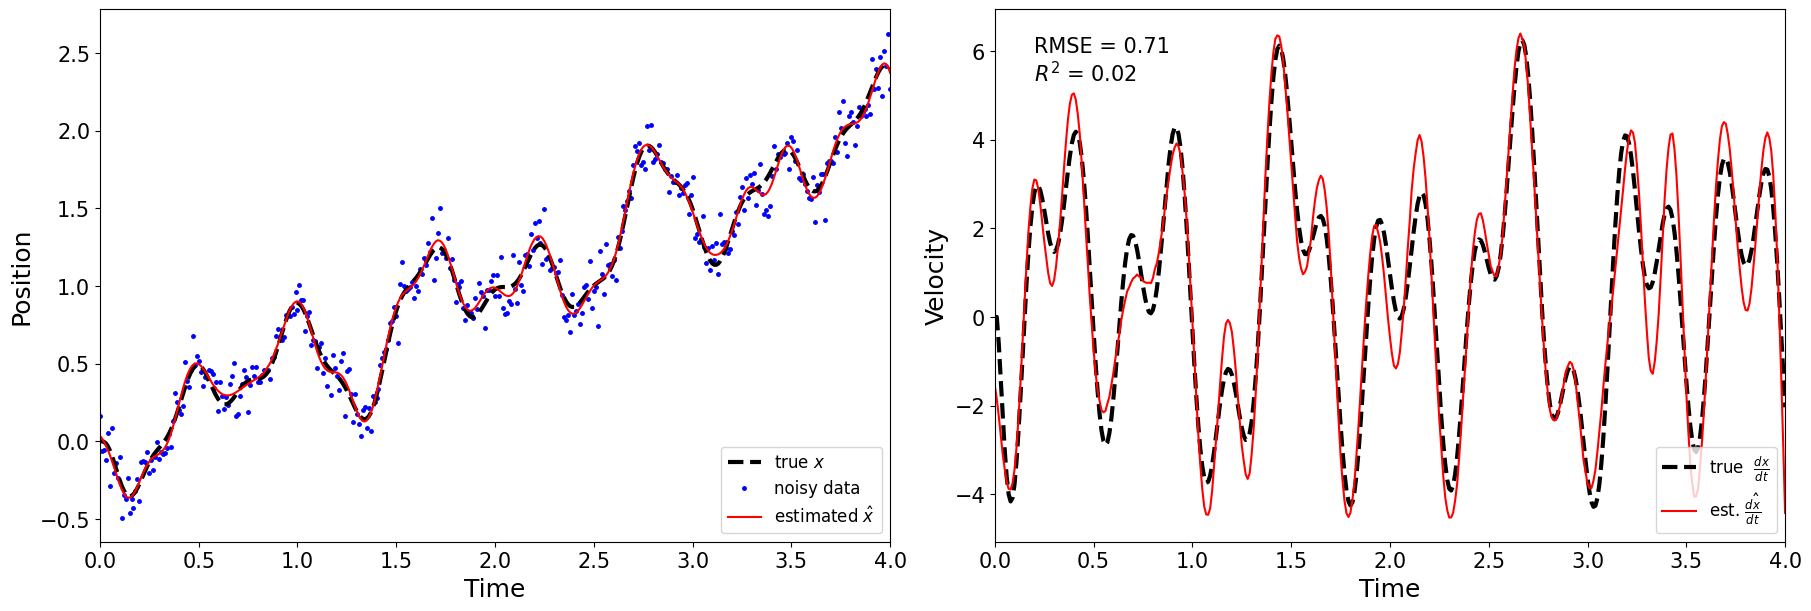

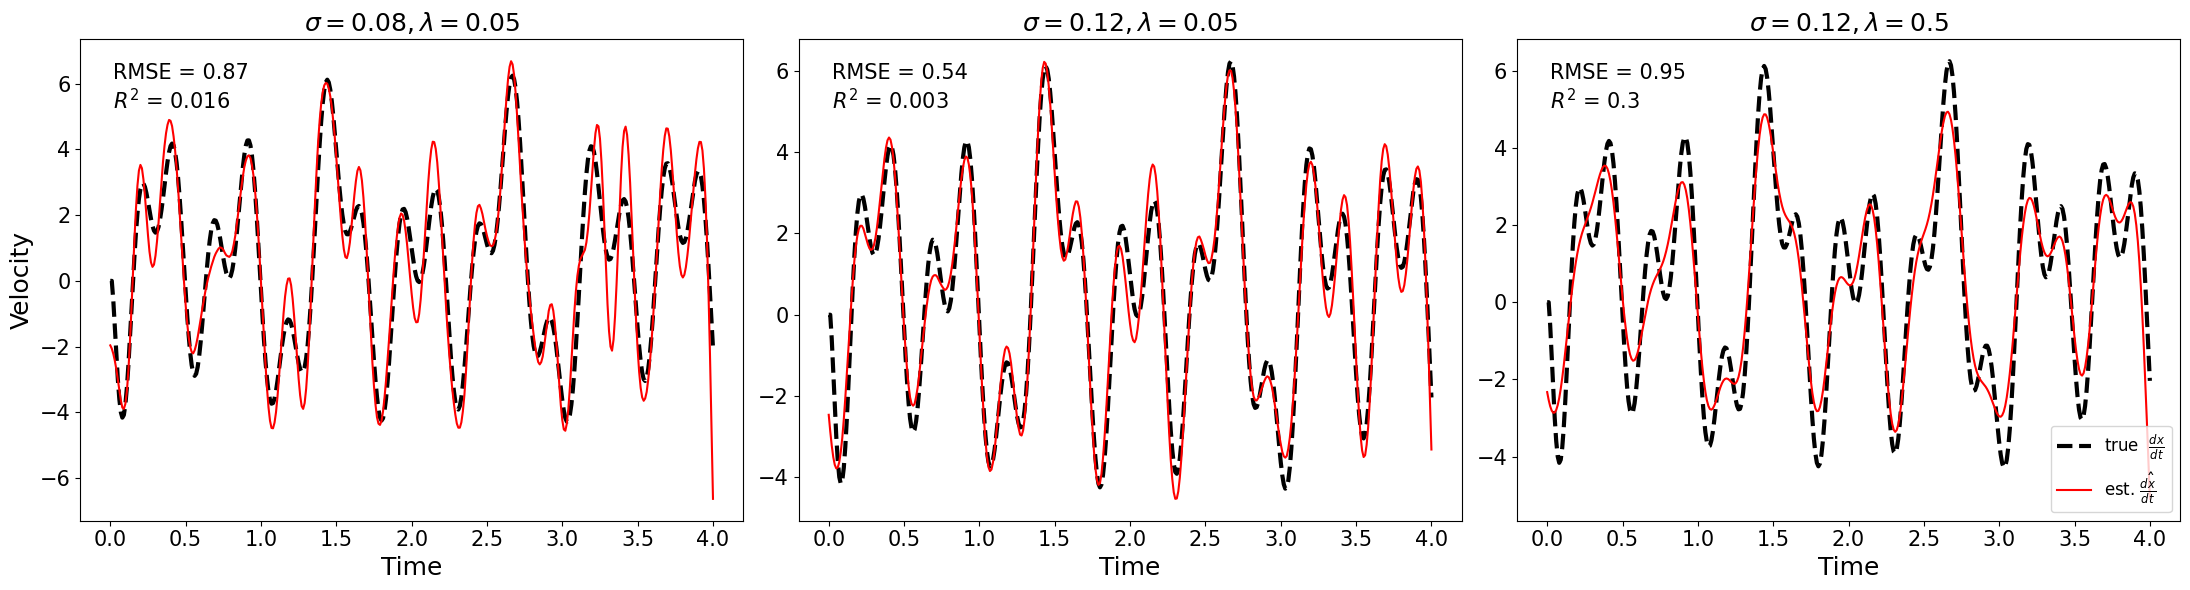

In [13]:
x_hat, dxdt_hat = pynumdiff.basis_fit.rbfdiff(x, dt, sigma=0.1, lmbd=0.02)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

_, dxdt_hat1 = pynumdiff.basis_fit.rbfdiff(x, dt, sigma=0.08, lmbd=0.05)
_, dxdt_hat2 = pynumdiff.basis_fit.rbfdiff(x, dt, sigma=0.12, lmbd=0.05)
_, dxdt_hat3 = pynumdiff.basis_fit.rbfdiff(x, dt, sigma=0.12, lmbd=0.5)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, r"$\sigma=0.08, \lambda=0.05$",
                           dxdt_hat2, r"$\sigma=0.12, \lambda=0.05$",
                           dxdt_hat3, r"$\sigma=0.12, \lambda=0.5$")

## 5. Total Variation Regularization

Here we use the general `tvrdiff` function. There are also module functions `velocity`, `acceleration`, and `jerk`, which call the general function, with `order=1`, `2`, or `3`, respectively.

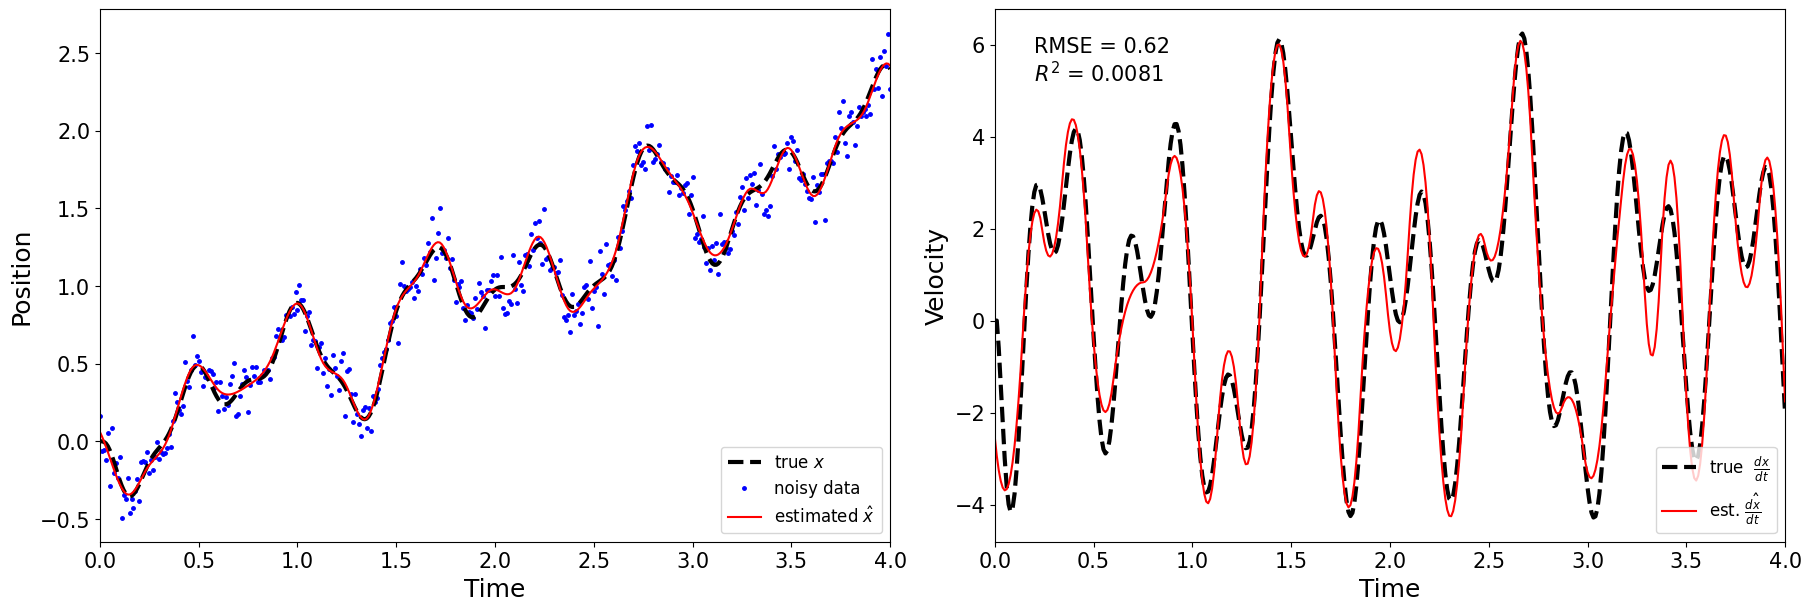

In [14]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.tvrdiff(x, dt, order=3, gamma=12)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

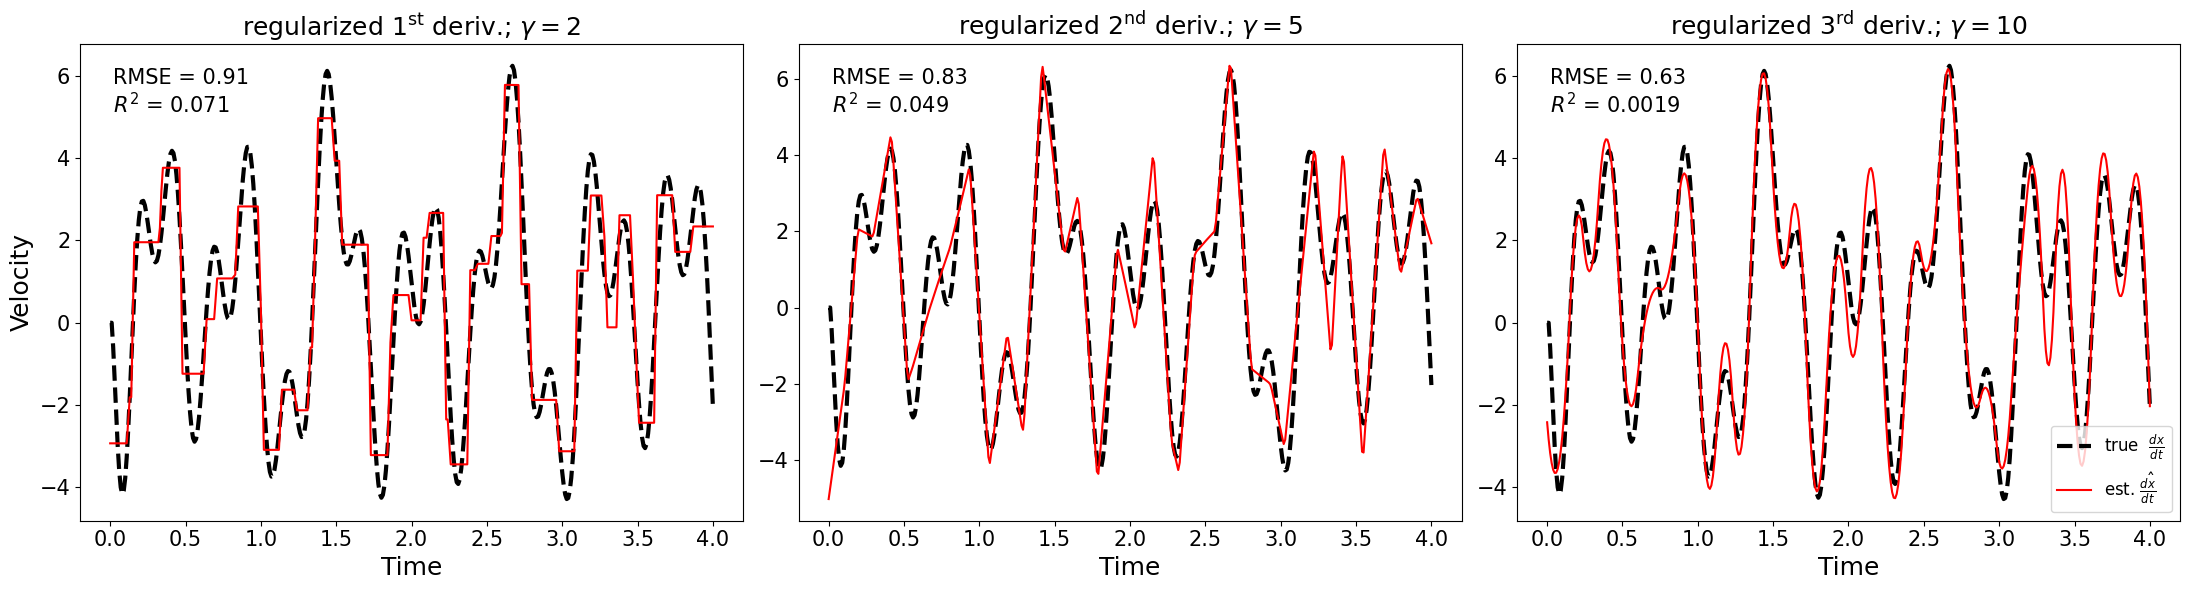

In [15]:
_, dxdt_hat1 = pynumdiff.total_variation_regularization.velocity(x, dt, gamma=2)
_, dxdt_hat2 = pynumdiff.total_variation_regularization.acceleration(x, dt, gamma=5)
_, dxdt_hat3 = pynumdiff.total_variation_regularization.jerk(x, dt, gamma=10)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, rf'regularized $1^\text{{st}}$ deriv.; $\gamma=2$',
                          dxdt_hat2, rf"regularized $2^\text{{nd}}$ deriv.; $\gamma=5$",
                          dxdt_hat3, rf'regularized $3^\text{{rd}}$ deriv.; $\gamma=10$')

### 5.1 In case you don't have a convex solver

There is also a way to approximate the `order=1` solution of the above via iterative algorithm, detailed in Rick Chartrand's "Numerical differentiation of noisy, nonsmooth data". It's pretty mathematically involved, but he provides a script, which we call out to in the `iterative_velocity` function.

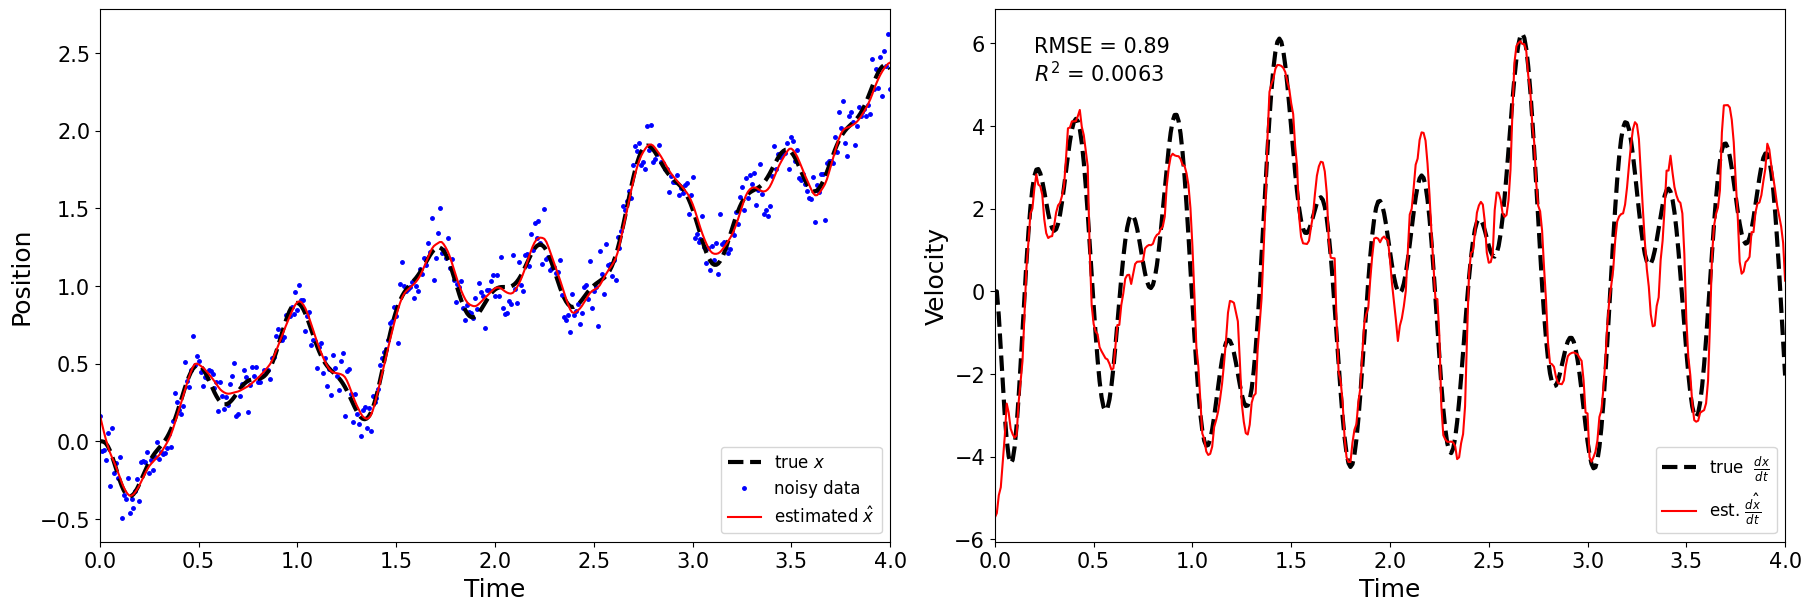

In [16]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.iterative_velocity(x, dt, num_iterations=1, gamma=0.001)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 5.2 Gaussian smoothing can be applied to get rid of sharp edges

TVR tends to select a sparse, stepwise solution for some derivative, which can leave sharp corners in first derivative estimations when order is 1 and 2.

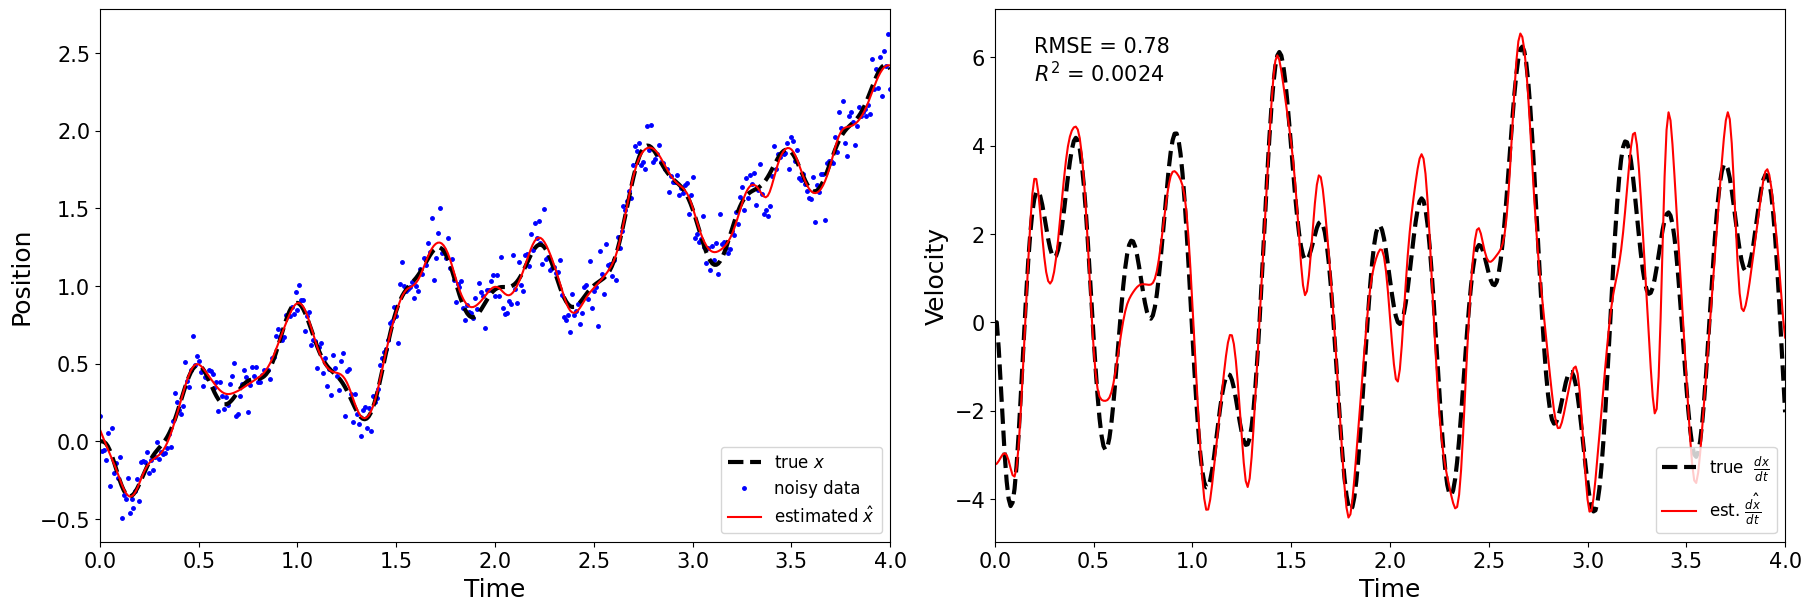

In [17]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.smooth_acceleration(x, dt, gamma=1, window_size=10)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 5.3 The method can be applied in a sliding window

This is similar to the approach taken by `polydiff`, except the idea is to keep the number of points manageable for the convex solver, because otherwise its results can sometimes be oversmooth.

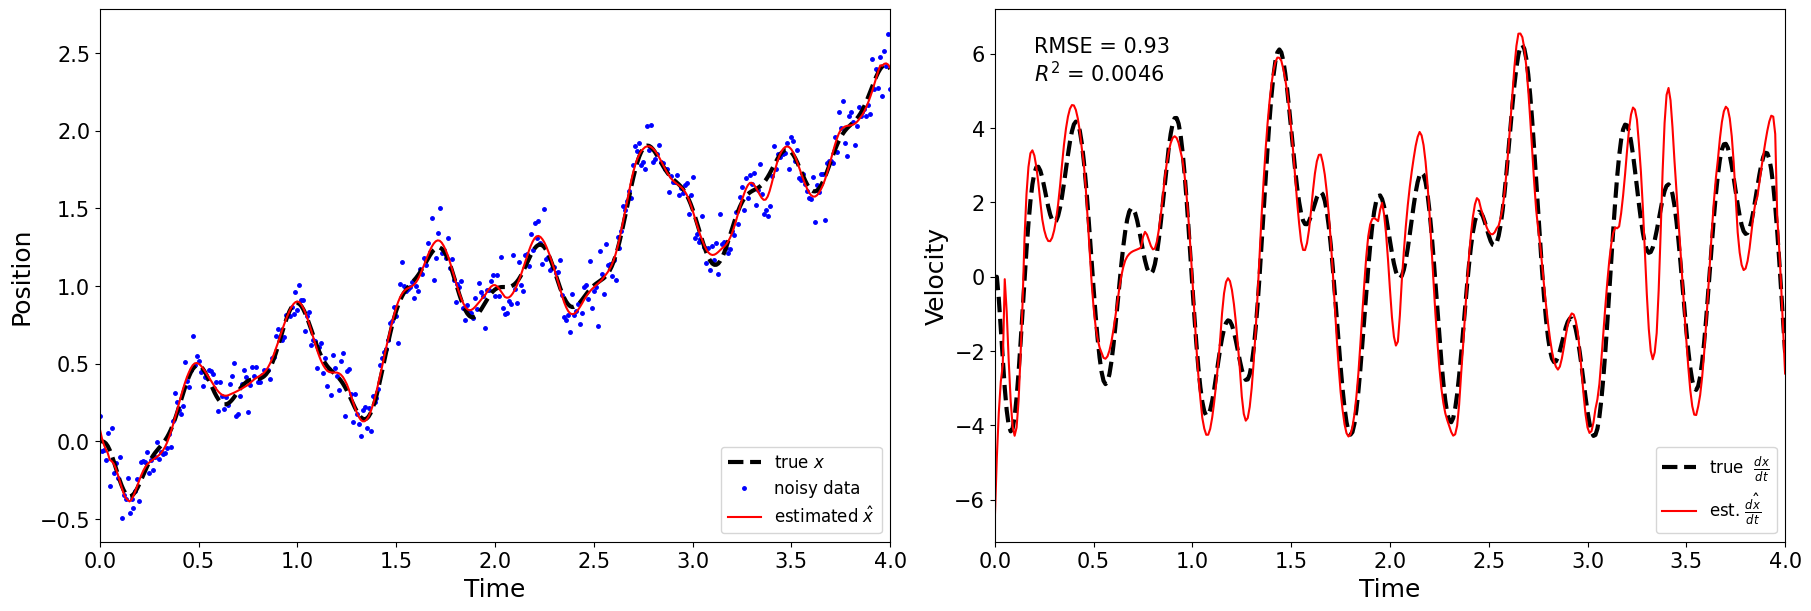

In [18]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.jerk_sliding(x, dt, gamma=10, window_size=51)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 6. Kalman smoothing

These methods assume a constant-derivative model and then employ model-based smoothing.

### 6.1 Rauch-Tung-Striebel

Here we use the general `rtsdiff` function. There are also module functions `constant_velocity`, `constant_acceleration`, and `constant_jerk`, which call the general function, with `order=1`, `2`, or `3`, respectively, and have separate `q` and `r` parameters rather than a `qr_ratio`.

In math, this solves the multistep Maximum A Priori (MAP) problem with a recursive algorithm, implicitly using an $\ell_2$ norm penalty on the state error.

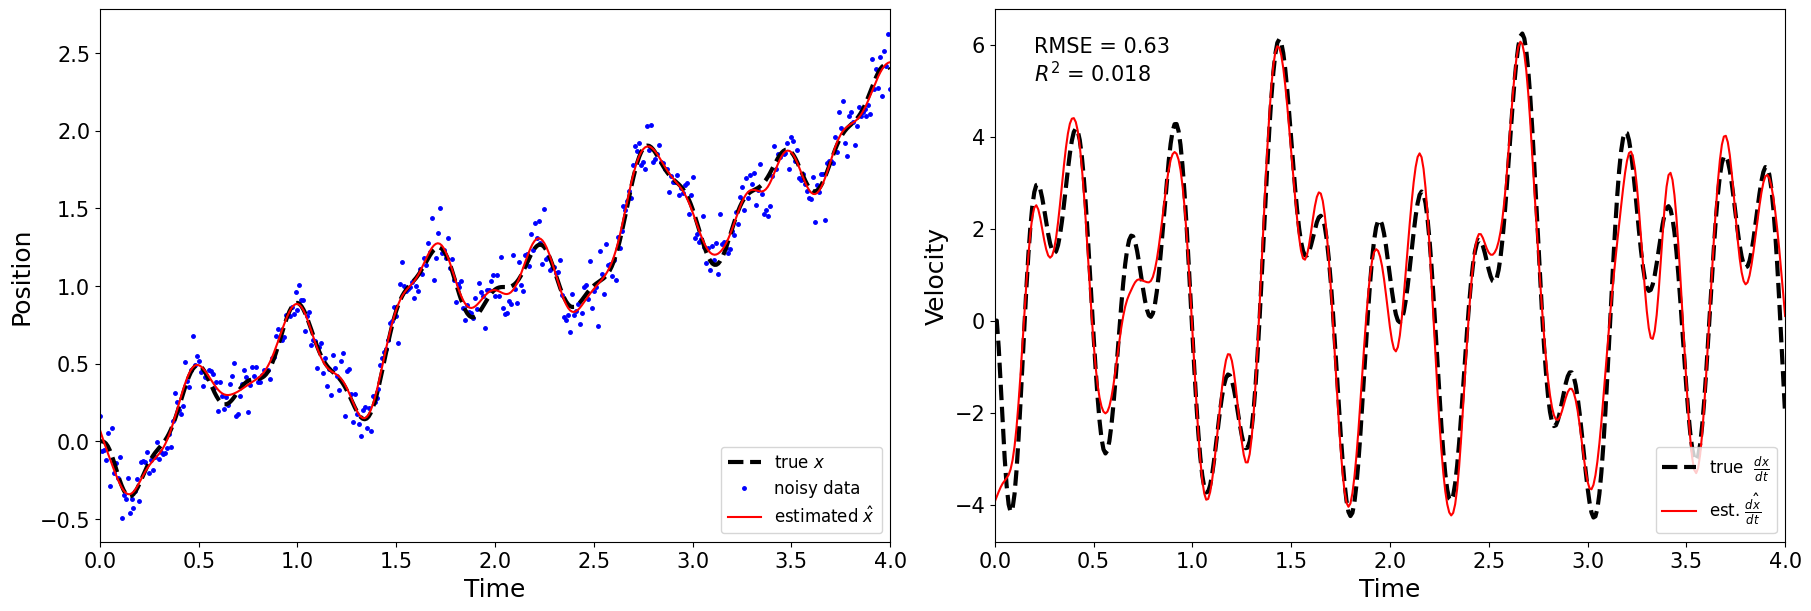

In [19]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.rtsdiff(x, dt, order=2, qr_ratio=1e7, forwardbackward=True)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

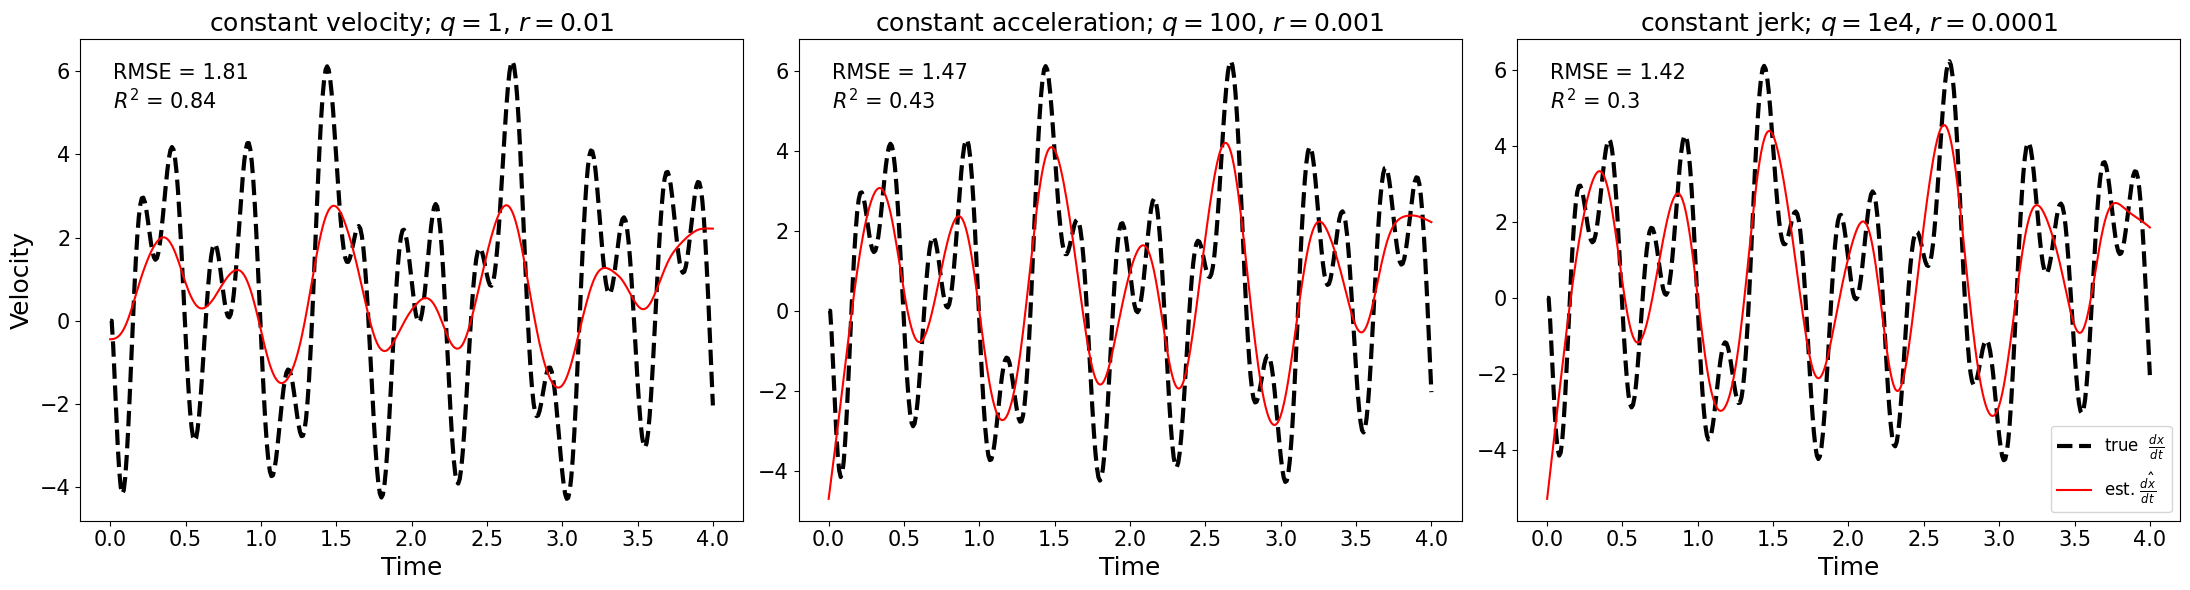

In [20]:
_, dxdt_hat1 = pynumdiff.kalman_smooth.constant_velocity(x, dt, forwardbackward=False, q=1, r=0.01)
_, dxdt_hat2 = pynumdiff.kalman_smooth.constant_acceleration(x, dt, forwardbackward=False, q=100, r=0.001)
_, dxdt_hat3 = pynumdiff.kalman_smooth.constant_jerk(x, dt, forwardbackward=False, q=1e4, r=0.0001)

evaluate.plot_comparison(dt, dxdt_truth, dxdt_hat1, rf'constant velocity; $q=1$, $r=0.01$',
                          dxdt_hat2, rf"constant acceleration; $q=100$, $r=0.001$",
                          dxdt_hat3, rf'constant jerk; $q=1\text{{e}}4$, $r=0.0001$')

### 6.2 Huber/$\ell_1$ Smoothing

Makes use of a convex solver, because there is no recursive solution.

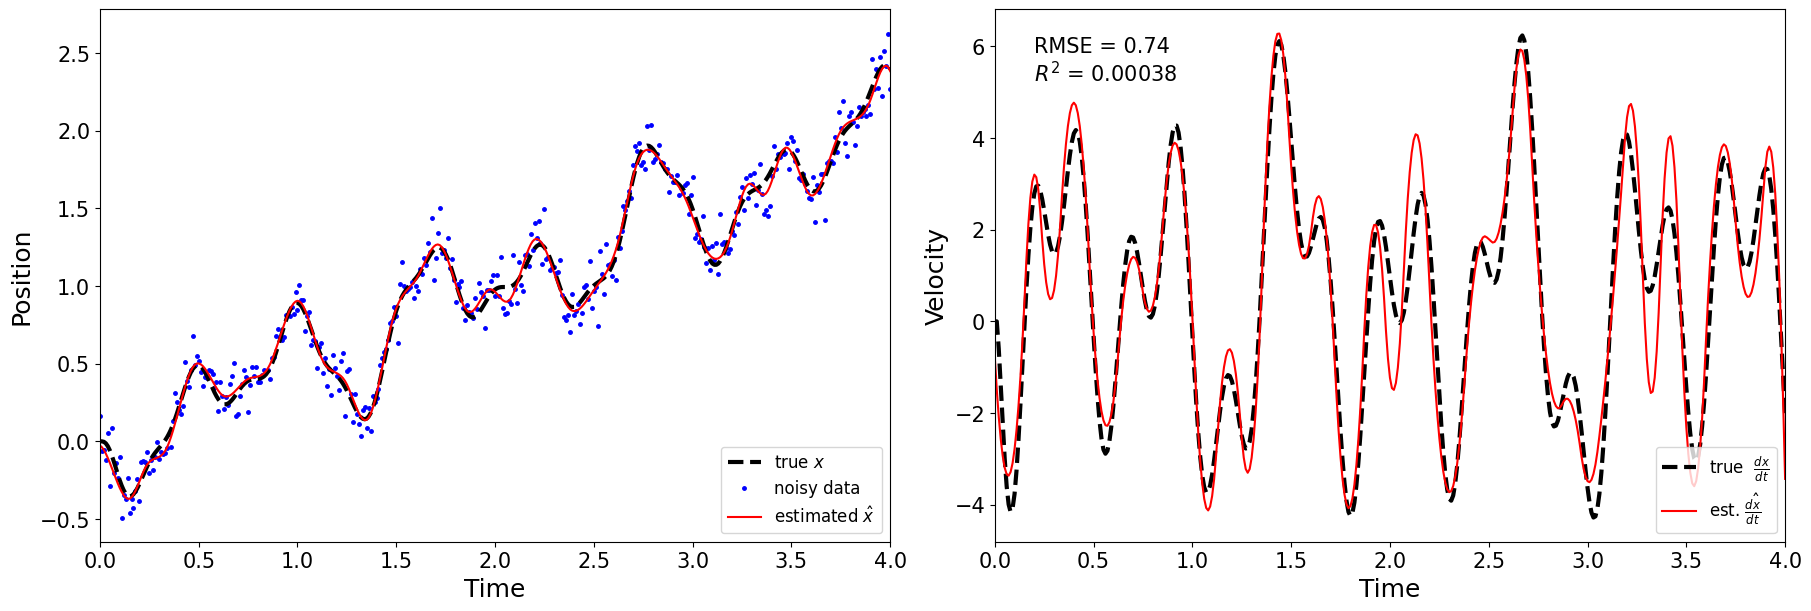

In [21]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.robustdiff(x, dt, order=3, qr_ratio=1e11, huberM=0)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 7. Sliding linear time invariant system fit

/usr/local/lib/python3.13/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


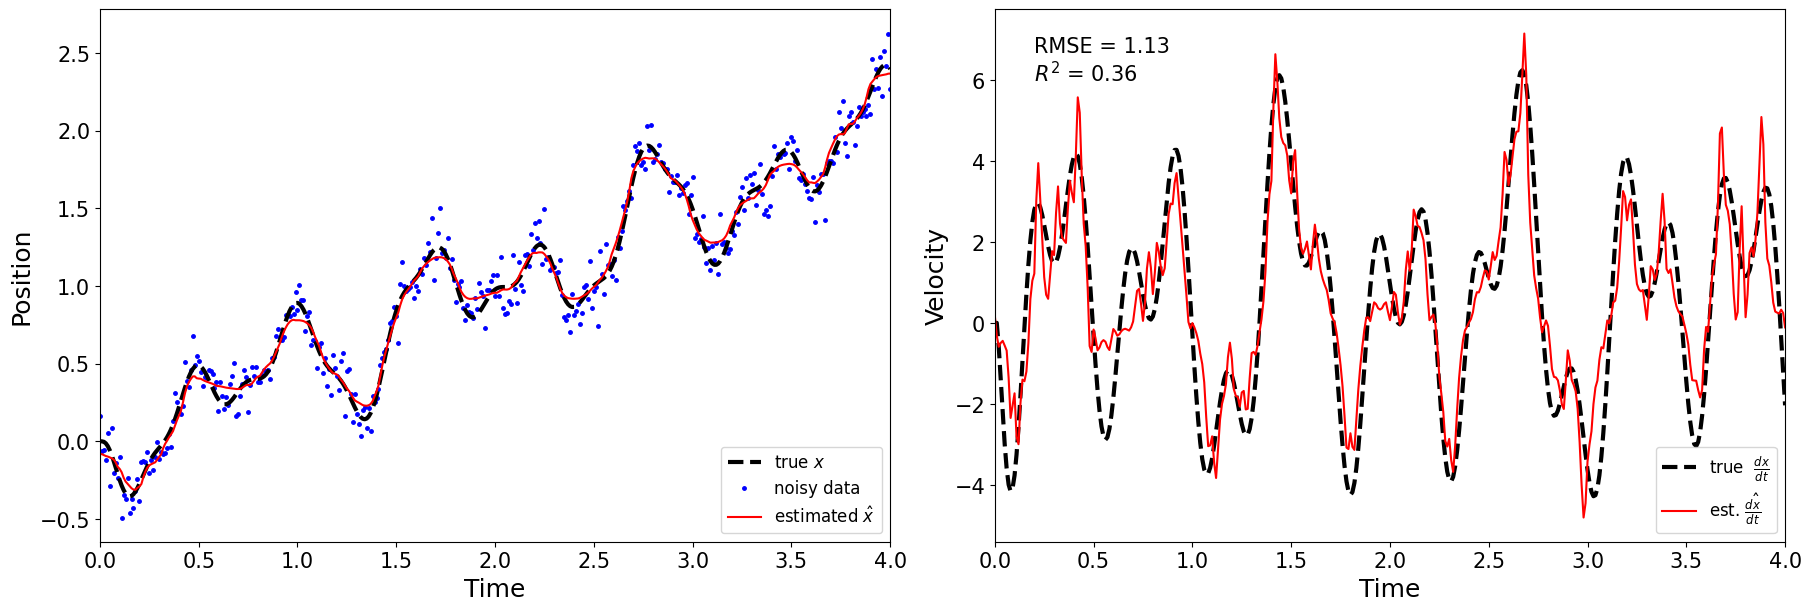

In [22]:
x_hat, dxdt_hat = pynumdiff.linear_model.lineardiff(x, dt, order=3, gamma=10, window_size=21)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);